In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from scipy.signal import find_peaks, peak_widths
import skimage

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [35]:
RANDOM_STATE = 26
INPUT_DATA = r"../../data/dataset_train.csv"
META_DATA = "data/metro_meta_data.xlsx"

# Metro in Porto, Portugal

## Data

### Description

[data](https://zenodo.org/record/6854240#.YvuPmHZBzBV)

[paper](https://arxiv.org/pdf/2207.05466.pdf#view=fitH&toolbar=1)

Notes:
- Meta data is stored in an external excel file.
- Digital variables assume only two values: `0` when inactive or `1` when activated.

In [4]:
# img = skimage.io.imread("images/2022-08-26 15_07_17.png")
# fig = px.imshow(img, title="Pressure air unit")
# fig.update_traces(hovertemplate=None, hoverinfo="skip")
# fig.update_layout(margin=dict(l=20, r=20, t=40, b=20))
# fig.update_xaxes(visible=False)
# fig.update_yaxes(visible=False)
# fig.show()

### Columns

In [5]:
features_info = pd.read_excel(META_DATA, sheet_name = "features")
columns_to_hide = ["keep", "new_name", "description_long"]
features_info[["original_name", "variable_type", "description_short"]]

,original_name,variable_type,description_short
0,timestamp,na,timestamp
1,TP2,analogue,compressor pressure
2,TP3,analogue,pneumatic panel pressure
3,H1,analogue,H1 valve activation
4,DV_pressure,analogue,pressure drop when towers discharge water
5,Reservoirs,analogue,unknown
6,Oil_temperature,analogue,temperature of the compressor oil
7,Flowmeter,analogue,unknown
8,Motor_current,analogue,motor current
9,COMP,digital,compressor air intake valve


### Failures

In [7]:
reported_failures = pd.read_excel(META_DATA, sheet_name = "failures")
reported_failures

,id,failure_type,component,start,end
0,1,Air Leak,Air Dryer,2022-02-28 21:53:00,2022-03-01 02:00:00
1,2,Air Leak,Clients,2022-03-23 14:54:00,2022-03-23 15:24:00
2,3,Oil Leak,Compressor,2022-05-30 12:00:00,2022-06-02 06:18:00


## Preprocess

### Read

In [8]:
metro = pd.read_csv(INPUT_DATA)

### Get to know

In [9]:
metro.head(2)

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Flowmeter,Motor_current,COMP,...,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,gpsLong,gpsLat,gpsSpeed,gpsQuality
0,2022-01-01 06:00:00,-0.012,9.758,9.76,-0.028,1.576,63.35,19.049625,3.9550,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1
1,2022-01-01 06:00:01,-0.012,9.760,9.76,-0.028,1.578,63.25,19.049625,4.0275,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1


In [10]:
metro.shape

(10979546, 21)

In [11]:
metro.columns

Index(['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric',
       'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level',
       'Caudal_impulses', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'],
      dtype='object')

In [12]:
metro.dtypes

timestamp           object
TP2                float64
TP3                float64
H1                 float64
DV_pressure        float64
Reservoirs         float64
Oil_temperature    float64
Flowmeter          float64
Motor_current      float64
COMP                 int64
DV_eletric           int64
Towers               int64
MPG                  int64
LPS                  int64
Pressure_switch      int64
Oil_level            int64
Caudal_impulses      int64
gpsLong            float64
gpsLat             float64
gpsSpeed             int64
gpsQuality           int64
dtype: object

### Check for missing values

In [13]:
metro.isna().any()

timestamp          False
TP2                False
TP3                False
H1                 False
DV_pressure        False
Reservoirs         False
Oil_temperature    False
Flowmeter          False
Motor_current      False
COMP               False
DV_eletric         False
Towers             False
MPG                False
LPS                False
Pressure_switch    False
Oil_level          False
Caudal_impulses    False
gpsLong            False
gpsLat             False
gpsSpeed           False
gpsQuality         False
dtype: bool

### Select columns

In [14]:
columns_to_keep = features_info[features_info.keep == "yes"].original_name
metro = metro[columns_to_keep]

### Rename columns

In [15]:
new_names = features_info[features_info.keep == "yes"].new_name
new_names.name = ""
metro.columns = new_names

### Set index

In [16]:
metro.timestamp = pd.to_datetime(metro.timestamp)
metro = metro.set_index("timestamp")

In [17]:
metro.index[0], metro.index[-1]

(Timestamp('2022-01-01 06:00:00'), Timestamp('2022-06-02 15:49:53'))

## Explore

### Group columns

Divide the columns in groups for easier filtering during EDA:
- `analogue_columns` = signal is continuous
- `digital_columns` = 1 or 0
- `gps_columns` = spatial data

In [18]:
used_columns = features_info[features_info.keep == "yes"]
columns_by_type = used_columns.groupby("variable_type")
columns_by_type.groups

{'analogue': [1, 2, 3, 4, 5, 6, 7, 8], 'digital': [9, 10, 11, 12, 13, 15], 'gps data': [17, 18, 19, 20], 'na': [0]}

In [19]:
analogue_columns = columns_by_type.get_group("analogue").new_name
digital_columns = columns_by_type.get_group("digital").new_name
gps_columns = columns_by_type.get_group("gps data").new_name

all_columns = np.concatenate([analogue_columns, digital_columns])

### Time series

#### Smoothing

Smooth the analogue columns.

In [1]:
# span = 60
# metro_smooth_analogue = metro[analogue_columns].ewm(span = span).mean()

NameError: name 'metro' is not defined

#### Single day

In [110]:
def plot_multiple_columns(df, cols, title=""):
    num_plots = len(cols)
    fig, axs = plt.subplots(num_plots, figsize = (12, 3 * num_plots), sharex=True)
    for i, col in enumerate(cols):
        axs[i].plot(df[col])
        axs[i].set_ylabel(col)
        axs[i].set_title(col)
    axs[-1].set_xlabel("Time")
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

In [ ]:
single_day = "('2022-01-10 08:00' < timestamp) & (timestamp < '2022-01-10 23:00')"
plot_multiple_columns(metro.query(single_day), analogue_columns)

#### Single day morning

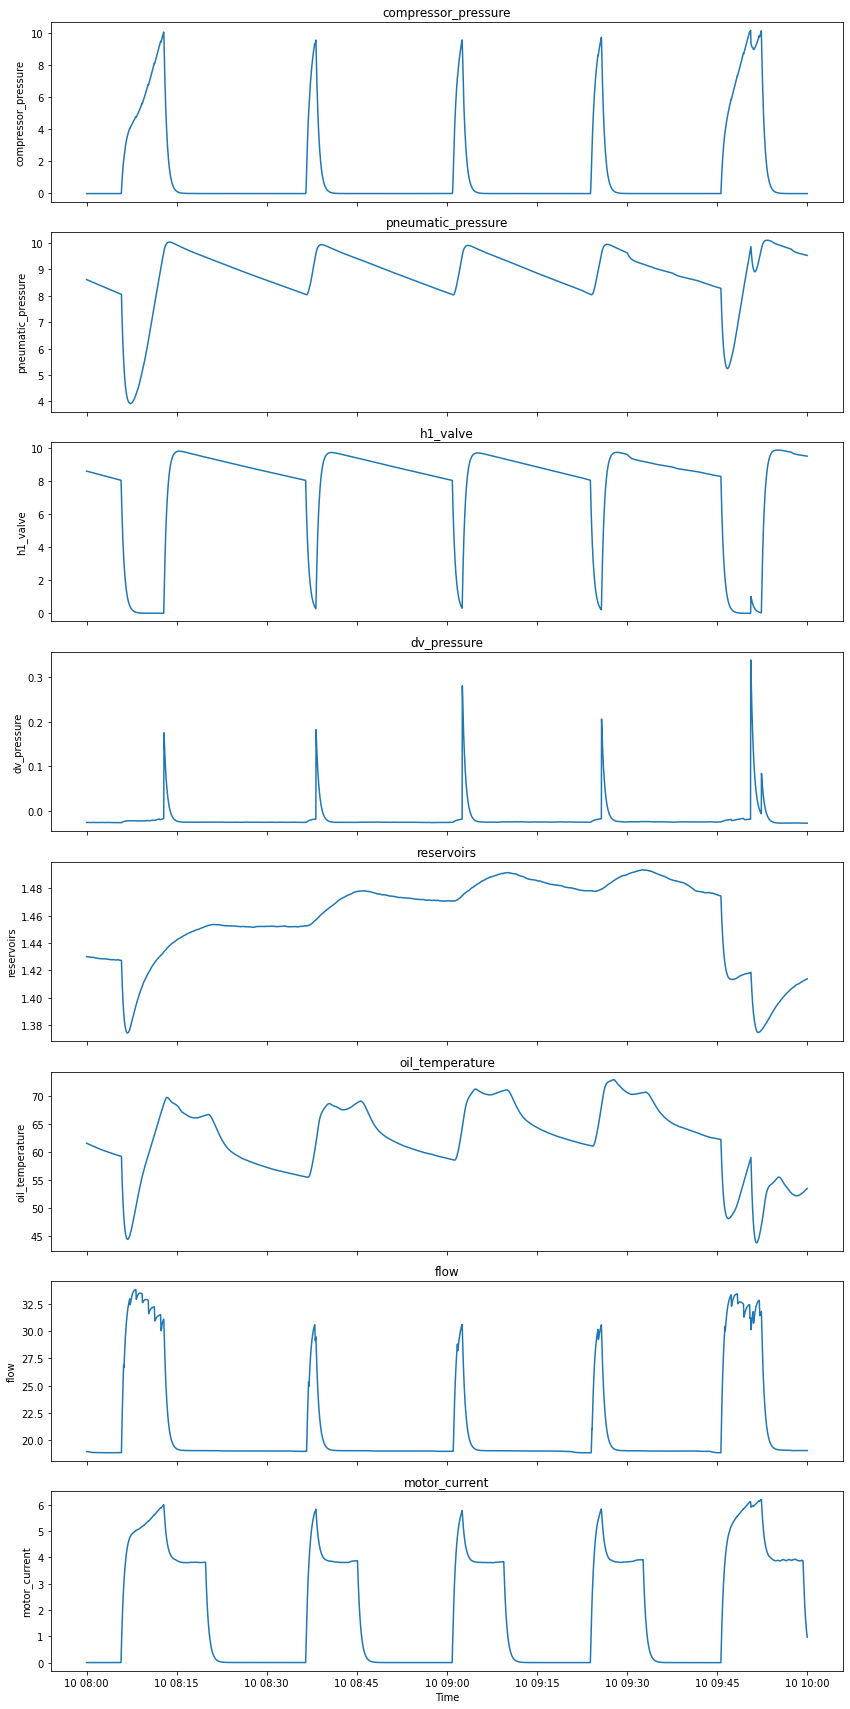

In [111]:
morning = "('2022-01-10 08:00' < timestamp) & (timestamp < '2022-01-10 10:00')"
plot_multiple_columns(metro_smooth_analogue.query(morning), analogue_columns)

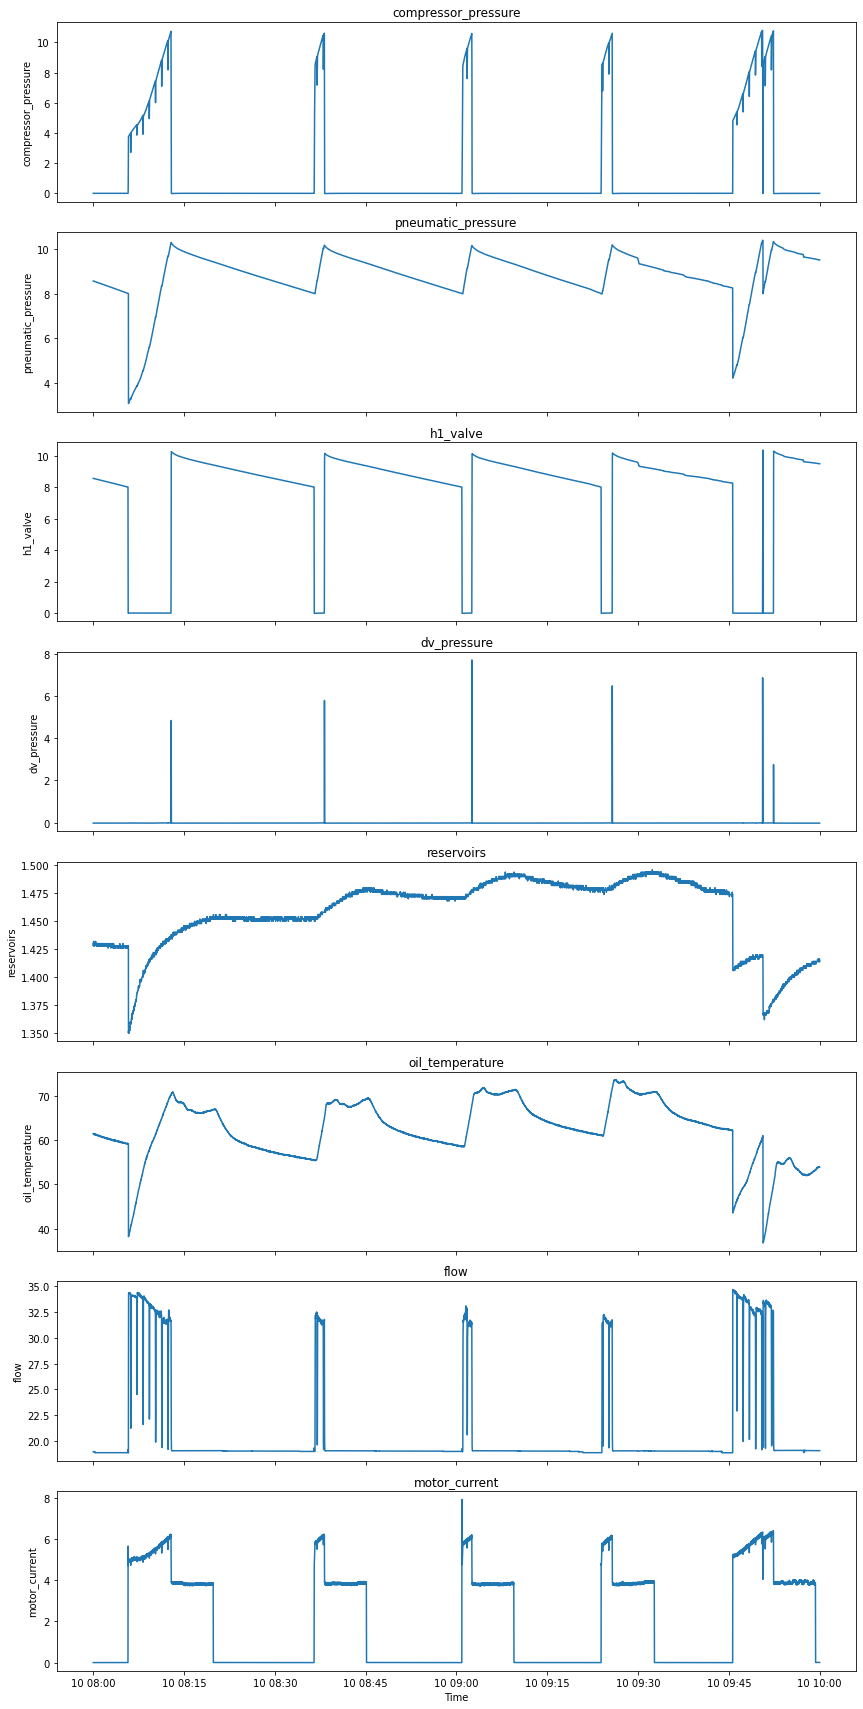

In [114]:
morning = "('2022-01-10 08:00' < timestamp) & (timestamp < '2022-01-10 10:00')"
plot_multiple_columns(metro.query(morning), analogue_columns)

#### First failure

In [23]:
# Info
reported_failures[reported_failures.id == 1]

,id,failure_type,component,start,end
0,1,Air Leak,Air Dryer,2022-02-28 21:53:00,2022-03-01 02:00:00


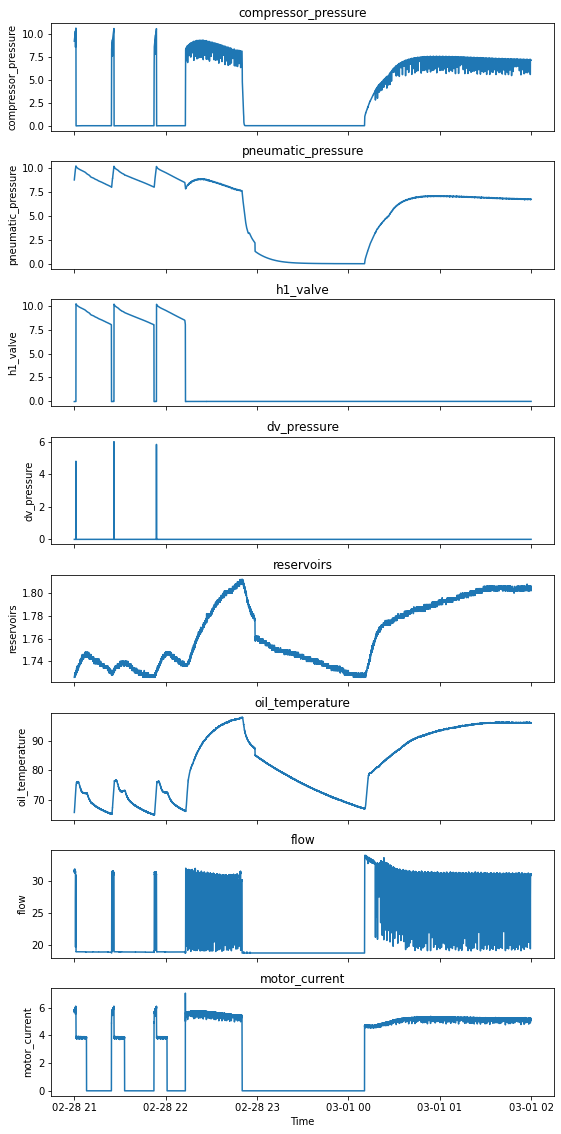

In [24]:
failure_interval = "('2022-02-28 21:00' <= timestamp) & (timestamp <= '2022-03-01 03:00')"
first_failure = metro.query(failure_interval)

plot_multiple_columns(first_failure, analogue_columns)

#### Second failure

In [25]:
# Info
reported_failures[reported_failures.id == 2]

,id,failure_type,component,start,end
1,2,Air Leak,Clients,2022-03-23 14:54:00,2022-03-23 15:24:00


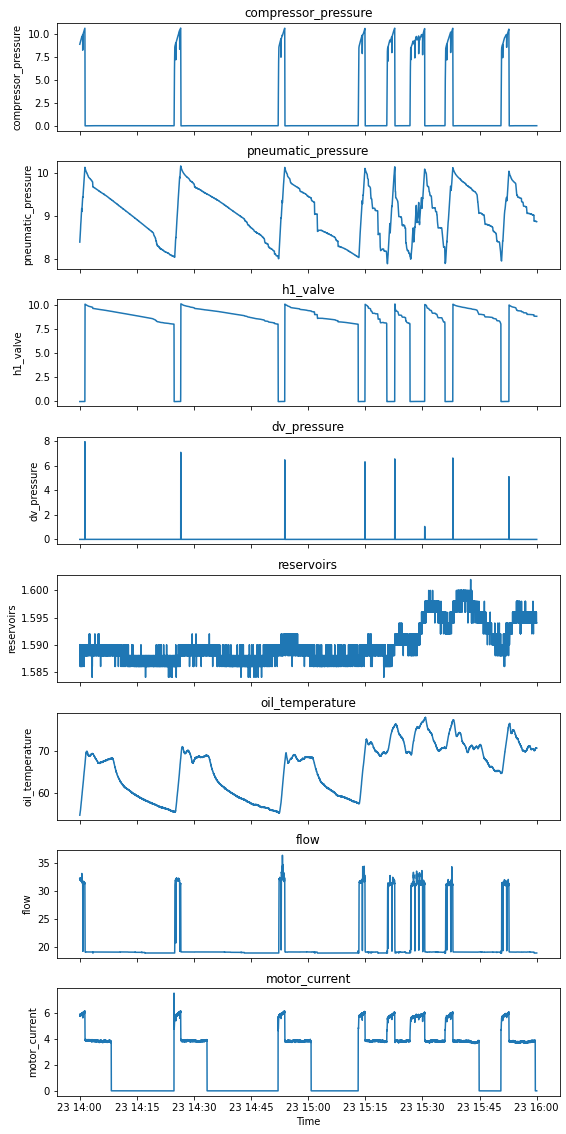

In [26]:
failure_interval = "('2022-03-23 14:00' <= timestamp) & (timestamp <= '2022-03-23 16:00')"
second_failure = metro.query(failure_interval)

plot_multiple_columns(second_failure, analogue_columns)

#### Third failure

In [50]:
# Info
reported_failures[reported_failures.id == 3]

,id,failure_type,component,start,end
2,3,Oil Leak,Compressor,2022-05-30 12:00:00,2022-06-02 06:18:00


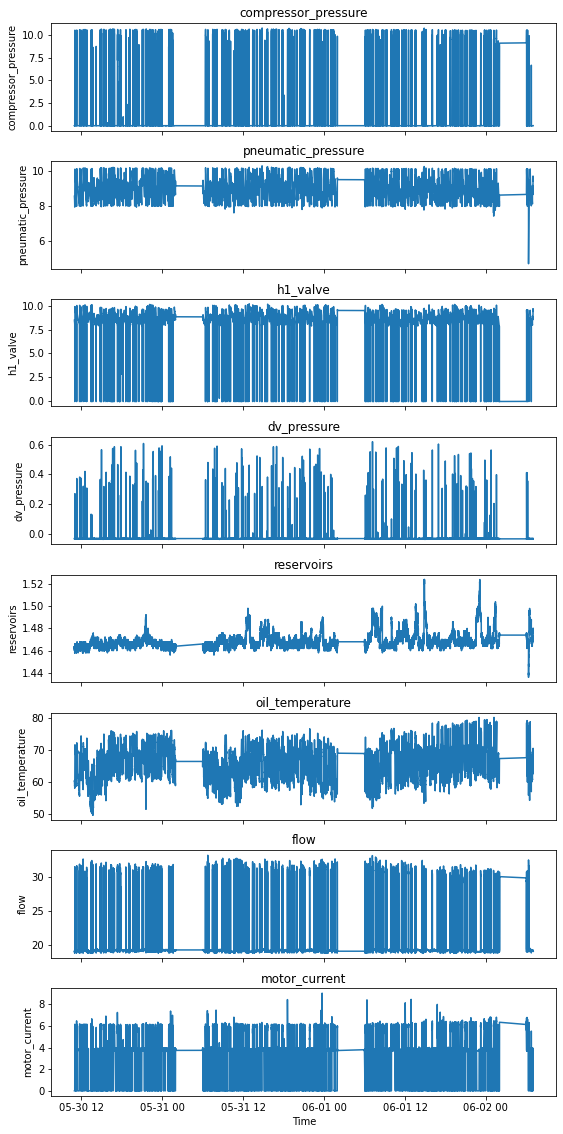

In [28]:
failure_interval = "('2022-05-30 11:00' <= timestamp) & (timestamp <= '2022-06-02 07:00')"
third_failure = metro.query(failure_interval)

plot_multiple_columns(third_failure, analogue_columns)

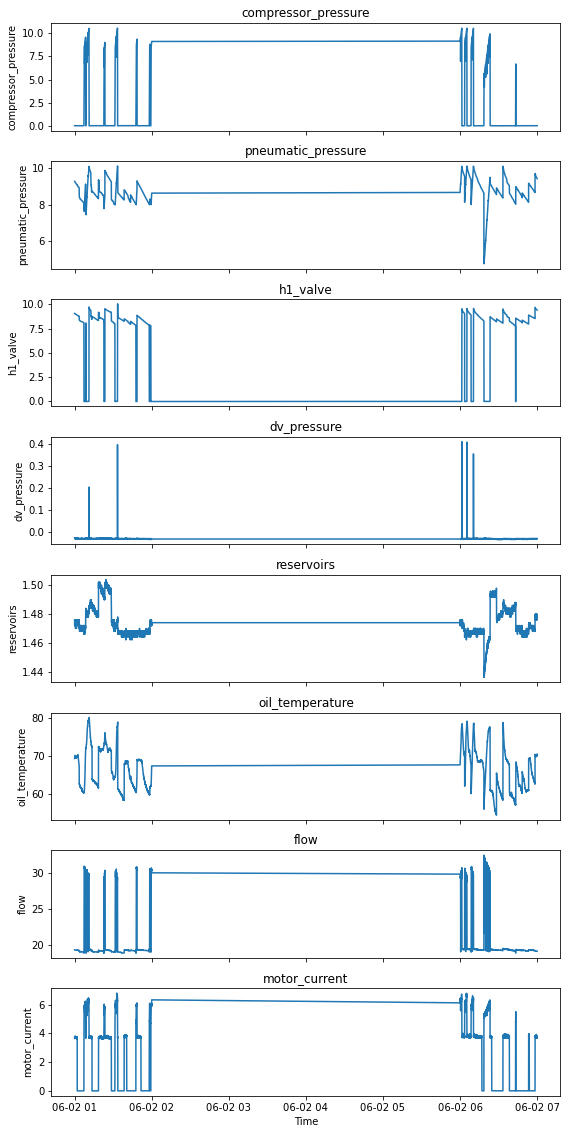

In [29]:
failure_interval = "('2022-06-02 01:00' <= timestamp) & (timestamp <= '2022-06-02 07:00')"
third_failure_2 = metro.query(failure_interval)

plot_multiple_columns(third_failure_2, analogue_columns)

### Geographic data

#### Train speed

In [30]:
metro[gps_columns].head(2)

,lon,lat,speed,quality
timestamp,,,,
2022-01-01 06:00:00,-8.65934,41.2124,0,1
2022-01-01 06:00:01,-8.65934,41.2124,0,1


In [31]:
start = "2022-01-10 08:00"
end = "2022-01-10 12:00"
query = f"('{start}' <= timestamp) & (timestamp <= '{end}') & (quality == 1)"
gps_data = metro[gps_columns].query(query)

In [32]:
# fig = px.scatter_mapbox(
#     gps_data, 
#     lat="lat", 
#     lon="lon", 
#     color = "speed", 
#     # zoom=10, 
#     title=f"Metro route and speed from {start} to {end}",
# )

# fig.update_layout(mapbox_style="carto-positron")
# fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
# fig.show()

#### Stations

In [36]:
stations = pd.read_excel(META_DATA, sheet_name = "stations")
stations

,station,lat,lon
0,Casa da Música,41.160787,-8.628263
1,Francos,41.166533,-8.636390
2,Senhor de Matosinhos,41.188205,-8.685120
3,Senhora da Hora,41.188119,-8.654463
4,Esposade,41.216089,-8.654543


#### Train speed and stations

Observations:
- Low train speed indicates a station. The stations match with the indication.

In [37]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scattermapbox(
#         lat=gps_data.lat,
#         lon=gps_data.lon,
#         marker = go.scattermapbox.Marker(color = gps_data.speed),
#         name = "Train speed",
#     )
# )

# fig.add_trace(
#     go.Scattermapbox(
#         lat=stations.lat,
#         lon=stations.lon,
#         mode='markers',
#         marker=go.scattermapbox.Marker(
#             size=16,
#             color='green',
#             opacity=0.6,
#             ),
#         text=stations.station,
#         name = "Stations",
#     )
# )

# fig.update_layout(
#     mapbox_style="carto-positron",
#     margin={"r":0,"t":30,"l":0,"b":0},
#     title="Train speed and stations",
# )
# fig.show()

#### Failure locations

Select narrower failure intervals based on the abnormalities in sensor readings observed in above analyses.

Also filter out the invalid gps readings (`[metro.quality == 1]`).

The third failure is omitted since:
- there is no valid GPS data in the failure period
- the time of occurrence can't be determined as the reported duration is much longer than the other two (2 days vs 1-2 hours)

In [38]:
interval = "('2022-02-28 22:00' <= timestamp) & (timestamp <= '2022-03-01 01:00')"
first_breakdown = metro[metro.quality == 1].query(interval)

interval = "('2022-03-23 14:54' <= timestamp) & (timestamp <= '2022-03-23 15:24')"
second_breakdown = metro[metro.quality == 1].query(interval)

for breakdown in [first_breakdown, second_breakdown]:
    print(breakdown.shape)

(10801, 18)
(1801, 18)


In [39]:
# fig = go.Figure()

# # Failures
# for breakdown, label in zip([first_breakdown, second_breakdown], ['First failure', 'Second failure']):
#     fig.add_trace(
#         go.Scattermapbox(
#             lat=breakdown.lat,
#             lon=breakdown.lon,
#             opacity=0.5,
#             marker={"size": 5,},
#             name=label,
#         )
#     )

# # Stations
# fig.add_trace(
#     go.Scattermapbox(
#         lat=stations.lat,
#         lon=stations.lon,
#         marker={
#             "size": 15,
#         },
#         text = stations.station,
#         name = "Stations"
#     )
# )

# fig.update_layout(
#     mapbox_style="carto-positron",
#     margin={"r":0,"t":30,"l":0,"b":0},
#     title="Failure and station locations"
# )
# fig.show()

#### GPS data quality

In [40]:
interval = "('2022-02-10 01:00' <= timestamp) & (timestamp <= '2022-06-02 06:00')"
quality_third_failure = metro.query(interval).quality

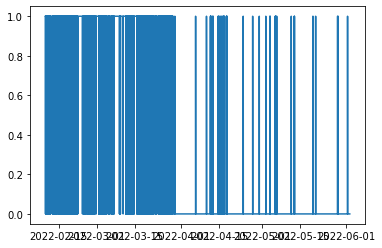

In [41]:
plt.plot(quality_third_failure)
plt.show()

# TODO: threshold by frequency to remove noise

### Signal peaks 

#### One variable

Steps:
1. Filter data for a short period and with proper GPS quality.
2. Select one analogue sensor signal. Find its peaks.
3. Plot to validate result.

`compressor_pressure` is chosen as signal because its shape seems suitable.

In [42]:
start = "2022-01-10 08:00"
end = "2022-01-10 12:00"
one_hour = f"('{start}' <= timestamp) & (timestamp <= '{end}') & (quality == 1)"
metro_one_hour = metro.query(one_hour)

In [43]:
signal = metro_one_hour.compressor_pressure
peak_indeces, _ = find_peaks(signal, height=10, distance=300)
peaks = signal.iloc[peak_indeces].copy()

Peaks count: 11


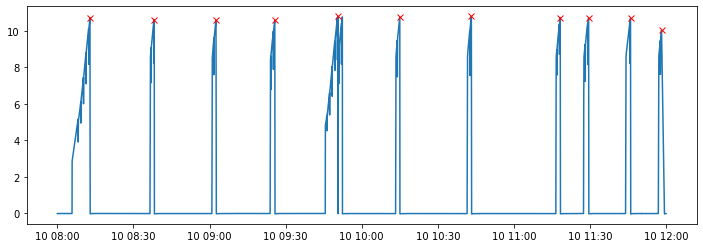

In [44]:
print(f"Peaks count: {len(peaks)}")

plt.figure(figsize = (12, 4))
plt.plot(signal)
plt.plot(peaks, "rx")
plt.show()

In [45]:
# fig1 = px.line(signal)
# fig2 = px.scatter(peaks, color_discrete_sequence=['#ff7f0e'])
# fig3 = go.Figure(data=fig1.data + fig2.data)
# fig3.show()

### Compare peeks to stations

In [46]:
peaks_gps_data = metro_one_hour[metro_one_hour.index.isin(peaks.index)][["lon", "lat"]]

stations_and_peaks = pd.concat([stations, peaks_gps_data], keys=["station", "peak"])
stations_and_peaks = stations_and_peaks.reset_index()
stations_and_peaks = stations_and_peaks.drop(columns=["level_1"])
stations_and_peaks = stations_and_peaks.rename(columns={"level_0": "location_type"})

stations_and_peaks

,location_type,station,lat,lon
0,station,Casa da Música,41.160787,-8.628263
1,station,Francos,41.166533,-8.636390
2,station,Senhor de Matosinhos,41.188205,-8.685120
3,station,Senhora da Hora,41.188119,-8.654463
4,station,Esposade,41.216089,-8.654543
5,peak,NaN,41.213400,-8.660810
6,peak,NaN,41.213200,-8.660880
7,peak,NaN,41.213300,-8.660830
8,peak,NaN,41.212900,-8.658770
9,peak,NaN,41.211800,-8.658800


In [47]:
# fig = px.scatter_mapbox(
#     data_frame = stations_and_peaks,
#     lat="lat",
#     lon="lon",
#     color="location_type",
# )

# fig.update_layout(
#     mapbox_style="carto-positron",
#     margin={"r":0,"t":30,"l":0,"b":0},
#     title="Peeks and stations"
# )
# fig.show()

In [48]:
# fig = go.Figure()

# # Sensor peaks
# fig.add_trace(
#     go.Scattermapbox(
#         lat=peaks_gps_data.lat,
#         lon=peaks_gps_data.lon,
#         name = "Compressor pressure peaks",
#     )
# )

# # Stations
# fig.add_trace(
#     go.Scattermapbox(
#         lat=stations.lat,
#         lon=stations.lon,
#         mode="markers",
#         marker={
#             "size": 15,
#         },
#         text = stations.station,
#         name = "Stations"
#     )  
# )

# fig.update_layout(
#     mapbox_style="carto-positron",
#     margin={"r":0,"t":30,"l":0,"b":0},
#     title="Failure and station locations"
# )
# fig.show()

### Plot widths
`peak_widths` returns a `tuple(width, y, x_start, x_end)`

In [49]:
widths = peak_widths(x, peaks, rel_height=0.95)
widths 

NameError: name 'x' is not defined

In [ ]:
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.hlines(y = widths[1], xmin = widths[2], xmax = widths[3], color="red")
plt.xlim((1000, 1500))
plt.show()

In [ ]:
fig1 = px.line(x)
fig2 = px.scatter(x = peaks, y = x[peaks], color_discrete_sequence=['#ff7f0e'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.show()

In [ ]:
plt.plot(metro.Reservoirs)
plt.show()

### Smoothing

In [64]:
first_failure

,compressor_pressure,pneumatic_pressure,h1_valve,dv_pressure,reservoirs,oil_temperature,flow,motor_current,compressor_intake_valve,compressor_outlet_valve,tower,mpg,lps,oil_level,lon,lat,speed,quality
timestamp,,,,,,,,,,,,,,,,,,
2022-02-28 21:00:00,9.178,8.730,-0.010,-0.022,1.726,65.625,31.346000,5.6525,0,1,0,0,0,0,-8.65939,41.2136,0,1
2022-02-28 21:00:01,9.222,8.790,-0.008,-0.022,1.726,65.850,31.476813,5.8225,0,1,0,0,0,0,-8.65939,41.2136,0,1
2022-02-28 21:00:02,9.246,8.820,-0.008,-0.022,1.726,65.950,31.588938,5.7075,0,1,0,0,0,0,-8.65939,41.2136,0,1
2022-02-28 21:00:03,9.266,8.836,-0.008,-0.022,1.726,66.025,31.448781,5.7275,0,1,0,0,0,0,-8.65939,41.2136,0,1
2022-02-28 21:00:04,9.292,8.866,-0.006,-0.020,1.726,66.125,31.729094,5.8650,0,1,0,0,0,0,-8.65939,41.2136,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01 01:59:56,7.126,6.698,0.004,-0.020,1.804,96.100,30.972250,5.0475,0,1,0,0,1,0,-8.65941,41.2135,0,1
2022-03-01 01:59:57,7.126,6.702,0.006,-0.020,1.804,96.050,31.018969,5.1525,0,1,0,0,1,0,-8.65941,41.2135,0,1
2022-03-01 01:59:58,7.126,6.712,0.006,-0.020,1.804,95.950,30.878812,5.0775,0,1,0,0,1,0,-8.65941,41.2135,0,1


In [63]:
first_failure.compressor_pressure.ewm(span = 60).mean()

timestamp
2022-02-28 21:00:00    9.178000
2022-02-28 21:00:01    9.200367
2022-02-28 21:00:02    9.216088
2022-02-28 21:00:03    9.229196
2022-02-28 21:00:04    9.242608
                         ...   
2022-03-01 01:59:56    7.090696
2022-03-01 01:59:57    7.091853
2022-03-01 01:59:58    7.092973
2022-03-01 01:59:59    7.094318
2022-03-01 02:00:00    7.095553
Name: compressor_pressure, Length: 18001, dtype: float64

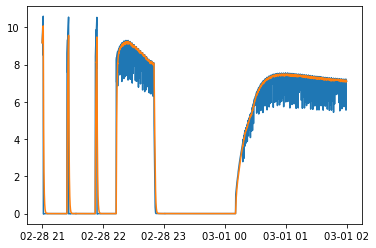

In [65]:
plt.plot(first_failure.compressor_pressure)
plt.plot(first_failure.compressor_pressure.ewm(span = 60).mean())
plt.show()

## Future work

Ideas how to continue the analysis:
- Create a new column with the type of the location: "during traveling" or when "at station". Do this by checking if a set of coordinates is inside the station vicinity (e.g. a circle with specific radius).
- Compare data for the same location (e.g. station) but in different days.
- Smooth the data.
- Model the data (and make predictions?).